In [1]:
from pyspark.sql import SparkSession
import os

In [2]:
spark = SparkSession.builder \
    .appName("EDA") \
    .master("yarn") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/27 07:40:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load merged data

In [4]:
# Example path in HDFS
merged_parquet_path = "hdfs:///data/psi_weather_merged.parquet"

df_merged = spark.read.parquet(merged_parquet_path)

df_merged.printSchema()
df_merged.show(5)

root
 |-- north: integer (nullable = true)
 |-- south: integer (nullable = true)
 |-- east: integer (nullable = true)
 |-- west: integer (nullable = true)
 |-- central: integer (nullable = true)
 |-- psi_date: date (nullable = true)
 |-- psi_hour: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- precipprob: integer (nullable = true)
 |-- preciptype: string (nullable = true)
 |-- snow: integer (nullable = true)
 |-- snowdepth: integer (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- sealevelpressure: double (nullable = true)
 |-- cloudcover: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- solarradiation: double (nullable = true)
 |-- solarenergy: double (nullable = t

25/07/27 07:42:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------------+------------+
|north|south|east|west|central|  psi_date|psi_hour|     name|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|          conditions|               icon|            stations|weather_date|weather_hour|
+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------------+---------

# Create Temp View for Spark SQL to run queries like spark.sql("SELECT * FROM psi_weather_merged LIMIT 10").show()

In [5]:
df_merged.createOrReplaceTempView("psi_weather_merged")

In [ ]:
spark.sql("SELECT * FROM psi_weather_merged LIMIT 10").show()

+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------------+------------+
|north|south|east|west|central|  psi_date|psi_hour|     name|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|          conditions|               icon|            stations|weather_date|weather_hour|
+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------------+---------

25/07/27 11:08:40 WARN HeartbeatReceiver: Removing executor 1 with no recent heartbeats: 6740530 ms exceeds timeout 120000 ms
25/07/27 11:08:40 ERROR YarnScheduler: Lost executor 1 on 831eb7adb9bb: Executor heartbeat timed out after 6740530 ms


# List unhealthy PSI (2014 - 2023)

In [ ]:
# OPTION 1 - spark SQL

unhealthy_sql = """
SELECT
  psi_date,
  psi_hour,
  north,
  south,
  east,
  west,
  central
FROM psi_weather_merged
WHERE (north >= 101 OR south >= 101 OR east >= 101 OR west >= 101 OR central >= 101)
  AND (YEAR(psi_date) BETWEEN 2014 AND 2023)
ORDER BY psi_date, psi_hour
"""

df_unhealthy_psi = spark.sql(unhealthy_sql)
df_unhealthy_psi.show(20)


+----------+--------+-----+-----+----+----+-------+
|  psi_date|psi_hour|north|south|east|west|central|
+----------+--------+-----+-----+----+----+-------+
|2023-10-07|       7|   65|   83| 102|  59|     93|
|2023-10-07|       8|   66|   84| 105|  60|     95|
|2023-10-07|       9|   67|   85| 107|  61|     97|
|2023-10-07|      10|   68|   87| 109|  62|     99|
|2023-10-07|      11|   68|   88| 111|  62|    102|
|2023-10-07|      12|   69|   90| 112|  63|    103|
|2023-10-07|      13|   70|   92| 114|  64|    104|
|2023-10-07|      14|   71|   94| 115|  65|    106|
|2023-10-07|      15|   72|   95| 117|  65|    107|
|2023-10-07|      16|   72|   96| 119|  66|    110|
|2023-10-07|      17|   73|   98| 120|  66|    112|
|2023-10-07|      18|   74|  100| 121|  67|    114|
|2023-10-07|      19|   75|  101| 122|  67|    115|
|2023-10-07|      20|   75|  101| 123|  67|    116|
|2023-10-07|      21|   75|  100| 123|  67|    117|
|2023-10-07|      22|   74|   99| 122|  67|    116|
|2023-10-07|

In [8]:
# OPTION 2 - DataFrame API

from pyspark.sql import functions as F

df_unhealthy_psi = (
    df_merged
    .filter(
        (F.col("north") >= 101) | 
        (F.col("south") >= 101) | 
        (F.col("east") >= 101) | 
        (F.col("west") >= 101) | 
        (F.col("central") >= 101)
    )
    .filter((F.year("psi_date") >= 2014) & (F.year("psi_date") <= 2023))
    .orderBy("psi_date", "psi_hour")
)
df_unhealthy_psi.show(20)


+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+--------------------+------------+------------+
|north|south|east|west|central|  psi_date|psi_hour|     name|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|      conditions|               icon|            stations|weather_date|weather_hour|
+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+--------------------+------------+------------+
|   65|

# Create column for avg PSI (4 or 5 regions)

In [10]:
# OPTION 1 - Spark SQL

avg_psi_sql = """
SELECT
  psi_date,
  psi_hour,
  (north + south + east + west + central) / 5.0 AS psi_avg,
  north, south, east, west, central,
  weather_hour, weather_date, temp, windspeed, precip
FROM psi_weather_merged
"""

df_avg_psi = spark.sql(avg_psi_sql)
df_avg_psi.show(10)



+----------+--------+---------+-----+-----+----+----+-------+------------+------------+----+---------+------+
|  psi_date|psi_hour|  psi_avg|north|south|east|west|central|weather_hour|weather_date|temp|windspeed|precip|
+----------+--------+---------+-----+-----+----+----+-------+------------+------------+----+---------+------+
|2022-01-01|       0|26.800000|   29|   27|  32|  17|     29|           0|  2022-01-01|25.0|      5.2|   0.0|
|2022-01-01|       1|26.800000|   30|   25|  32|  18|     29|           1|  2022-01-01|24.3|      8.5| 3.473|
|2022-01-01|       2|26.800000|   30|   24|  31|  19|     30|           2|  2022-01-01|23.9|     13.9| 4.341|
|2022-01-01|       3|26.600000|   30|   23|  30|  19|     31|           3|  2022-01-01|24.0|      6.7| 0.868|
|2022-01-01|       4|26.600000|   31|   23|  29|  20|     30|           4|  2022-01-01|23.9|      3.0| 0.868|
|2022-01-01|       5|26.000000|   31|   23|  27|  19|     30|           5|  2022-01-01|24.0|      1.8|   0.0|
|2022-01-0

In [11]:
# OPTION 2 - DataFrame API

df_avg_psi = df_merged.withColumn(
    "psi_avg",
    (F.col("north") + F.col("south") + F.col("east") + F.col("west") + F.col("central")) / 5.0
)
df_avg_psi.show(10)


+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------------+------------+-------+
|north|south|east|west|central|  psi_date|psi_hour|     name|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|          conditions|               icon|            stations|weather_date|weather_hour|psi_avg|
+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------

In [13]:
# filter for rows where psi_avg >= 101
# compute correlation with windspeed or precipitation

df_unhealthy_avg = df_avg_psi.filter("psi_avg >= 10")

corr_windspeed = df_unhealthy_avg.stat.corr("psi_avg", "windspeed")
print("Correlation (unhealthy PSI vs windspeed):", corr_windspeed)

corr_precip = df_unhealthy_avg.stat.corr("psi_avg", "precip")
print("Correlation (unhealthy PSI vs precipitation):", corr_precip)


Correlation (unhealthy PSI vs windspeed): 0.07271051309409973
Correlation (unhealthy PSI vs precipitation): -0.029351302539901408


# Daily Max PSI and Corresponding Weather

In [15]:
from pyspark.sql import functions as F

# 1) Create a column 'psi_max_across_regions'
df_psi_weather = df_merged.withColumn(
    "psi_max_across_regions",
    F.greatest("north", "south", "east", "west", "central")
)

# 2) Create a daily group to find the max of this new column
df_daily_max = (
    df_psi_weather
    .groupBy("psi_date")
    .agg(F.max("psi_max_across_regions").alias("daily_max_psi"))
)

# 3) Join this info back to retrieve weather columns when daily PSI is at max
df_daily_max_details = df_daily_max.join(
    df_psi_weather,
    on=[
        (df_daily_max["psi_date"] == df_psi_weather["psi_date"]) &
        (df_daily_max["daily_max_psi"] == df_psi_weather["psi_max_across_regions"])
    ],
    how="inner"
)

# Now, df_daily_max_details has each day’s max PSI row with corresponding weather info
df_daily_max_details.show(10)

+----------+-------------+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------------+------------+----------------------+
|  psi_date|daily_max_psi|north|south|east|west|central|  psi_date|psi_hour|     name|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|          conditions|               icon|            stations|weather_date|weather_hour|psi_max_across_regions|
+----------+-------------+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+---------

In [16]:
# SQL Option

# Temp View
df_merged.createOrReplaceTempView("psi_weather_view")

# Create max PSI column in intermediate temp view
spark.sql("""
    CREATE OR REPLACE TEMP VIEW psi_weather_max AS
    SELECT
        *,
        GREATEST(north, south, east, west, central) AS psi_max_across_regions
    FROM psi_weather_view
""")

# Find daily max PSI
spark.sql("""
    CREATE OR REPLACE TEMP VIEW daily_max_psi AS
    SELECT
        psi_date,
        MAX(psi_max_across_regions) AS daily_max_psi
    FROM psi_weather_max
    GROUP BY psi_date
""")


# Join back to get weather details at peak PSI
df_daily_max_details = spark.sql("""
    SELECT m.* 
    FROM psi_weather_max m
    INNER JOIN daily_max_psi d
        ON m.psi_date = d.psi_date
       AND m.psi_max_across_regions = d.daily_max_psi
    ORDER BY m.psi_date
""")

df_daily_max_details.show(10)


+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------------+------------+----------------------+
|north|south|east|west|central|  psi_date|psi_hour|     name|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|          conditions|               icon|            stations|weather_date|weather_hour|psi_max_across_regions|
+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-----------------

# Wind-Related Aggregation: Group by Wind Direction "Buckets"

In [17]:
# Create “buckets” for wind directions (e.g., N = 0–45 or 315–359, E = 46–135, S = 136–225, W = 226–314).

def wind_direction_bucket(deg):
    # Example classification
    if deg >= 315 or deg < 45:
        return "North"
    elif deg >= 45 and deg < 135:
        return "East"
    elif deg >= 135 and deg < 225:
        return "South"
    else:
        return "West"

# 1) Create a UDF or use Spark SQL case statements
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

bucket_udf = udf(wind_direction_bucket, StringType())

df_bucketing = df_merged.withColumn("wind_bucket", bucket_udf(F.col("winddir")))

# 2) Aggregate by wind_bucket
df_by_wind = (
    df_bucketing
    .groupBy("wind_bucket")
    .agg(F.avg("north").alias("avg_north"), F.avg("south").alias("avg_south"))
)
df_by_wind.show()


+-----------+------------------+------------------+
|wind_bucket|         avg_north|         avg_south|
+-----------+------------------+------------------+
|      South|40.019565800053606|42.707317073170735|
|       East|40.457052797478326| 44.47412660887838|
|       West| 34.18105263157895| 39.60842105263158|
|      North|34.149581074420894| 40.74691966485954|
+-----------+------------------+------------------+



In [18]:
# SQL Option
# a. Create Temp View
df_merged.createOrReplaceTempView("psi_weather_view")

# b. CASE statements to bucket winddir degrees
spark.sql("""
    CREATE OR REPLACE TEMP VIEW wind_bucketed AS
    SELECT
        *,
        CASE
            WHEN winddir >= 315 OR winddir < 45  THEN 'North'
            WHEN winddir >= 45  AND winddir < 135 THEN 'East'
            WHEN winddir >= 135 AND winddir < 225 THEN 'South'
            ELSE 'West'
        END AS wind_bucket
    FROM psi_weather_view
""")

df_by_wind = spark.sql("""
    SELECT
        wind_bucket,
        AVG(north)   AS avg_north,
        AVG(south)   AS avg_south,
        AVG(east)    AS avg_east,
        AVG(west)    AS avg_west,
        AVG(central) AS avg_central
    FROM wind_bucketed
    GROUP BY wind_bucket
""")

df_by_wind.show()


+-----------+------------------+------------------+-----------------+------------------+-----------------+
|wind_bucket|         avg_north|         avg_south|         avg_east|          avg_west|      avg_central|
+-----------+------------------+------------------+-----------------+------------------+-----------------+
|      South|40.019565800053606|42.707317073170735|47.32189761458054| 38.36156526400429|45.23264540337711|
|       East|40.457052797478326| 44.47412660887838|50.11557656947728|37.810874704491724|48.24428684003152|
|       West| 34.18105263157895| 39.60842105263158|45.78526315789474|33.423508771929825|40.61824561403509|
|      North|34.149581074420894| 40.74691966485954|47.16375061606703| 33.65512567767373|41.62986692952193|
+-----------+------------------+------------------+-----------------+------------------+-----------------+



# Aggregation, GroupBy, Filter, Sort

In [19]:
# group by month or year

df_monthly = (
    df_avg_psi
    .groupBy(F.month("psi_date").alias("month"), F.year("psi_date").alias("year"))
    .agg(F.avg("psi_avg").alias("avg_monthly_psi"), F.avg("temp").alias("avg_temp"))
    .sort("year", "month")
)
df_monthly.show(12)


+-----+----+------------------+------------------+
|month|year|   avg_monthly_psi|          avg_temp|
+-----+----+------------------+------------------+
|    1|2022| 41.75698924731183| 27.70913978494625|
|    2|2022| 35.70952380952384|27.365178571428572|
|    3|2022|44.761559139784964|28.081182795698933|
|    4|2022|50.730000000000025|27.910833333333347|
|    5|2022| 44.38575268817199|29.102688172043038|
|    6|2022| 41.63861111111103|27.779444444444515|
|    7|2022| 42.97499999999995|28.539919354838702|
|    8|2022|44.268817204301065|27.996908602150533|
|    9|2022|  46.1138888888889|27.885277777777805|
|   10|2022| 35.14005376344087|27.535215053763455|
|   11|2022| 34.95145833333334|27.516354166666716|
|   12|2022|  33.6502688172043|26.744489247311826|
+-----+----+------------------+------------------+
only showing top 12 rows



In [ ]:
# SQL GroupBy

df_avg_psi.createOrReplaceTempView("psi_weather_avg")
monthly_sql = spark.sql("""
    SELECT
      YEAR(psi_date) AS yr,
      MONTH(psi_date) AS mon,
      AVG(psi_avg) AS avg_monthly_psi,
      AVG(temp) AS avg_monthly_temp
    FROM psi_weather_avg
    GROUP BY YEAR(psi_date), MONTH(psi_date)
    ORDER BY yr, mon
""")
monthly_sql.show(12)


+----+---+------------------+------------------+
|  yr|mon|   avg_monthly_psi|  avg_monthly_temp|
+----+---+------------------+------------------+
|2022|  1| 41.75698924731183| 27.70913978494625|
|2022|  2| 35.70952380952384|27.365178571428572|
|2022|  3|44.761559139784964|28.081182795698933|
|2022|  4|50.730000000000025|27.910833333333347|
|2022|  5| 44.38575268817199|29.102688172043038|
|2022|  6| 41.63861111111103|27.779444444444515|
|2022|  7| 42.97499999999995|28.539919354838702|
|2022|  8|44.268817204301065|27.996908602150533|
|2022|  9|  46.1138888888889|27.885277777777805|
|2022| 10| 35.14005376344087|27.535215053763455|
|2022| 11| 34.95145833333334|27.516354166666716|
|2022| 12|  33.6502688172043|26.744489247311826|
+----+---+------------------+------------------+
only showing top 12 rows



In [22]:
# Filter high PSI + low wind conditions, then sort by date:

df_high_psi_low_wind = (
    df_avg_psi
    .filter((F.col("psi_avg") >= 10) & (F.col("windspeed") < 3))
    .orderBy("psi_date", "psi_hour")
)
df_high_psi_low_wind.show()


+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------------+------------+-------+
|north|south|east|west|central|  psi_date|psi_hour|     name|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|          conditions|               icon|            stations|weather_date|weather_hour|psi_avg|
+-----+-----+----+----+-------+----------+--------+---------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+--------------------+-------------------+--------------------+------

# Save Aggregated Data to HDFS

In [23]:
df_high_psi_low_wind_path = "hdfs:///data/df_high_psi_low_wind.parquet"

df_high_psi_low_wind.write.mode("overwrite").parquet(df_high_psi_low_wind_path)


# Visualization

In [24]:
df_monthly_pd = df_monthly.toPandas()
print(df_monthly_pd.head(10))

   month  year  avg_monthly_psi   avg_temp
0      1  2022        41.756989  27.709140
1      2  2022        35.709524  27.365179
2      3  2022        44.761559  28.081183
3      4  2022        50.730000  27.910833
4      5  2022        44.385753  29.102688
5      6  2022        41.638611  27.779444
6      7  2022        42.975000  28.539919
7      8  2022        44.268817  27.996909
8      9  2022        46.113889  27.885278
9     10  2022        35.140054  27.535215


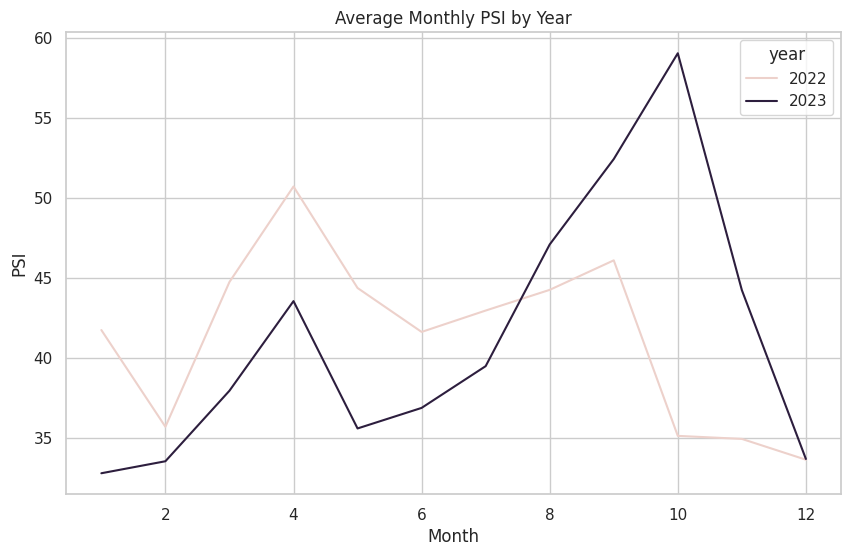

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="month", y="avg_monthly_psi", hue="year", data=df_monthly_pd)
plt.title("Average Monthly PSI by Year")
plt.ylabel("PSI")
plt.xlabel("Month")
plt.show()


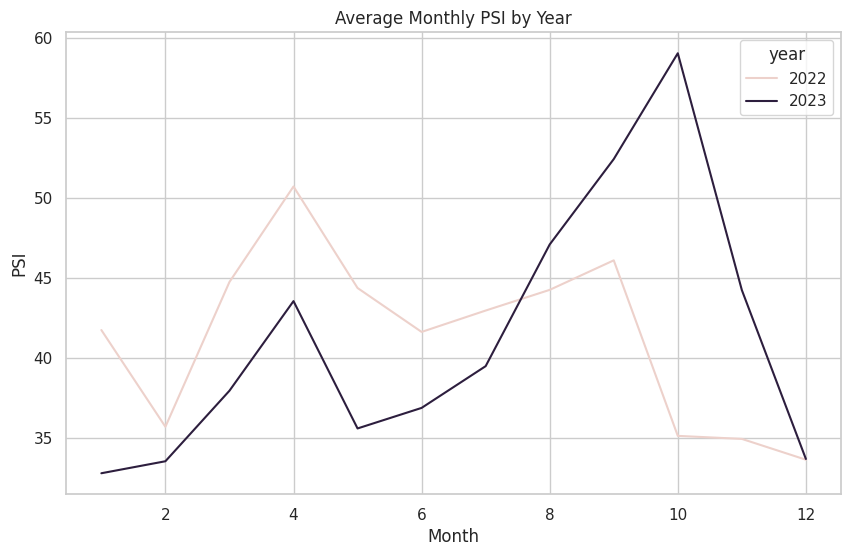

In [ ]:
# Aggregate daily or monthly data

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="month", y="avg_monthly_psi", hue="year", data=df_monthly_pd)
plt.title("Average Monthly PSI by Year")
plt.ylabel("PSI")
plt.xlabel("Month")
plt.show()


In [37]:
# convert pandas and sort by date

from pyspark.sql import functions as F

# Example: daily average PSI and temperature
df_daily = (
    df_avg_psi
    .groupBy("psi_date")
    .agg(
        F.avg("psi_avg").alias("daily_psi"),
        F.avg("temp").alias("daily_temp")
    )
.sort("psi_date")
)

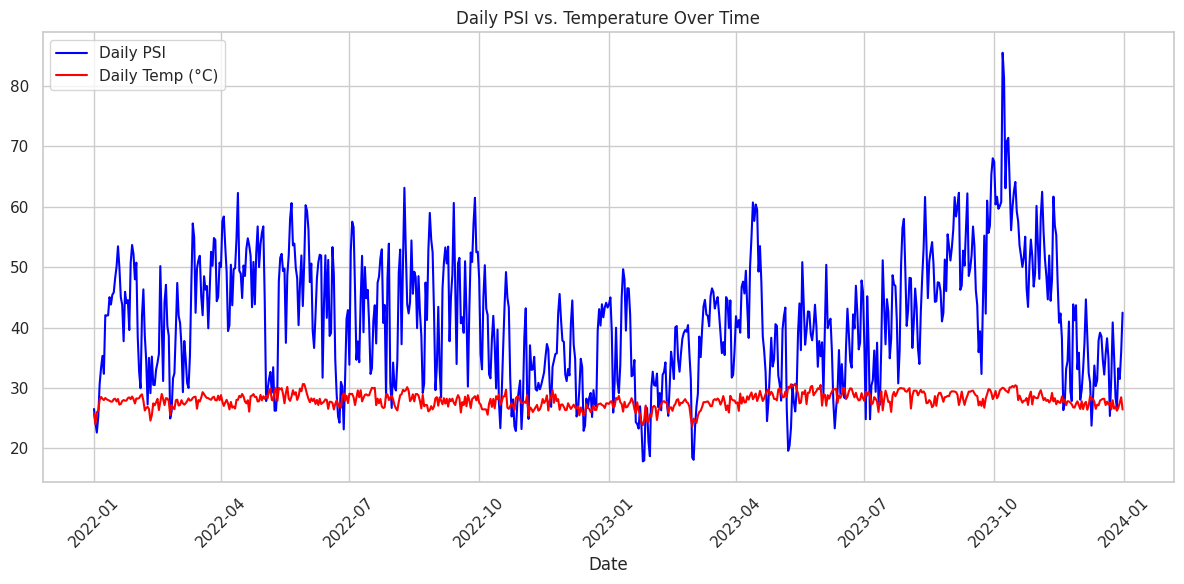

In [40]:
# Convert PySpark DataFrame to pandas DataFrame
df_pandas = df_daily.toPandas()

# Now plot using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df_pandas["psi_date"], df_pandas["daily_psi"], label="Daily PSI", color="blue")
plt.plot(df_pandas["psi_date"], df_pandas["daily_temp"], label="Daily Temp (°C)", color="red")
plt.title("Daily PSI vs. Temperature Over Time")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()